# Pre-training data governance from ethical lense linked to GDPD and EU AI Act (Adult Income)

steps
1. Load the Adult dataset (income prediction)
2. Run:
   - Basic data checks (pandas)
   - PII detection (Presidio)
   - Data minimisation
   - Data quality checks (Great Expectations)
   - Representation & outcome disparity analysis (pandas)
   - Fairness metrics (Fairlearn)

Linking each step to **GDPR** and **EU AI Act** concepts

In [ ]:

# !pip install pandas numpy matplotlib scikit-learn fairlearn great_expectations presidio-analyzer presidio-anonymizer


  Using cached ucimlrepo-0.0.7-py3-none-any.whl.metadata (5.5 kB)
Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)
   ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
   ------------------- -------------------- 2.4/4.9 MB 12.3 MB/s eta 0:00:01
   -------------------------------------- - 4.7/4.9 MB 17.8 MB/s eta 0:00:01
   ---------------------------------------- 4.9/4.9 MB 10.7 MB/s  0:00:00
   ---------------------------------------- 0.0/813.6 kB ? eta -:--:--
   ---------------------------------------- 813.6/813.6 kB 36.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 29.4 MB/s  0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   --- ------------------------------------ 3.4/41.2 MB 18.3 MB/s eta 0:00:03
   ----- ---------------------------------- 6.0/41.2 MB 14.2 MB/s eta 0:00:03
   --------------- ------------------------ 16.3/41.2 MB 26.3 MB

In [32]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine

import great_expectations as gx

from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

from datetime import datetime

plt.rcParams["figure.figsize"] = (6, 4)


## 1. Load the Adult Income dataset

Features: age, workclass, education, marital-status, occupation, sex, race, etc.
Protected attributes (for fairness analysis):sex, race and age


In [36]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

df = pd.read_csv(url, header=None, names=columns, skipinitialspace=True)

print(df.head())
print(df.shape)


   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

## 2. Basic overview (pandas)

Base overview od data
- Shape
- Data types
- Missingness pattern

(GDPR / EU AI Act) - regulatory 
- GDPR Art. 5(1)(d): data must be accurate


=============== Adult Income (Census): BASIC OVERVIEW ================
Shape: (32561, 15)

Dtypes:
 age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


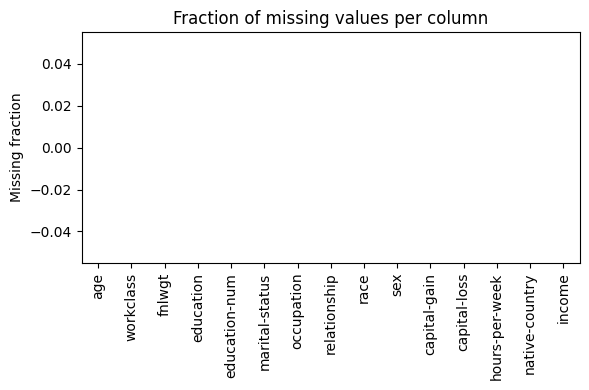

In [ ]:
def basic_overview(df: pd.DataFrame, dataset_name: str):
    print(f"\n=============== {dataset_name}: BASIC OVERVIEW ================")
    print("Shape:", df.shape)
    print("\nDtypes:\n", df.dtypes)


## 3. PII detection with Presidio

Scan text-like columns for potential PII using `AnalyzerEngine`.
- Identify columns that might contain identifiable text
- Use this to drive data minimisation

Regulatory: 
- GDPR Art. 5(1)(c): data minimisation
- GDPR Art. 25: privacy by design


In [38]:
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

def detect_pii_columns_with_presidio(df: pd.DataFrame):
    text_cols = df.select_dtypes(include=["object"]).columns
    pii_cols = []

    for col in text_cols:
        sample_text = " ".join(df[col].dropna().astype(str).head(50).tolist())
        if not sample_text:
            continue
        results = analyzer.analyze(text=sample_text,
                                   entities=[],
                                   language="en")
        if results:
            pii_cols.append(col)

    print("\n[Presidio] Potential PII columns:", pii_cols)
    return pii_cols

pii_cols = detect_pii_columns_with_presidio(df)



[Presidio] Potential PII columns: ['race', 'native-country']


## 4. Data minimisation

Ddrop PII columns that are not strictly necessary for our purpose.
- Protected attributes (`sex`, `race`, `age`) — we keep these only for fairness analysis (a legitimate interest).

In [ ]:
# Define target and protected attributes BEFORE minimisation step

target_col = "income"   
protected_cols = ["sex", "race", "age"]   

In [43]:

def apply_data_minimisation(
    df: pd.DataFrame,
    pii_cols: list,
    protected_cols: list,
    target_col: str
):
    cols_to_drop = [
        c for c in pii_cols
        if c not in protected_cols and c != target_col
    ]

    print("\nDropping columns (data minimisation):", cols_to_drop)
    df_min = df.drop(columns=cols_to_drop)
    print("Shape after minimisation:", df_min.shape)
    return df_min, cols_to_drop

df_min, dropped_cols = apply_data_minimisation(df, pii_cols, protected_cols, target_col)



Dropping columns (data minimisation): ['native-country']
Shape after minimisation: (32561, 14)


In [ ]:
df_min = df_min.copy()

# Convert income label to 0/1
df_min[target_col] = (df_min[target_col] == ">50K").astype(int)

# Create age_group
def age_to_group(age):
    if age < 30:
        return "<30"
    elif age <= 50:
        return "30-50"
    else:
        return ">50"

df_min["age_group"] = df_min["age"].astype(int).apply(age_to_group)

#  protected columns
protected_cols_extended = ["sex", "race", "age_group"]

df_min[[target_col, "sex", "race", "age", "age_group"]].head()


,income,sex,race,age,age_group
0,0,Male,White,39,30-50
1,0,Male,White,50,30-50
2,0,Male,White,38,30-50
3,0,Male,Black,53,>50
4,0,Female,Black,28,<30


## 6. Data quality checks with Great Expectations

Validate
- Numeric columns have no missing values
- The target (`income` as 0/1) is only in `{0, 1}`

regulatory:
- GDPR Art. 5(1)(d): data accuracy

In [ ]:
#need to test this with dataset having missing fields or synthetic dataset
def data_quality_with_great_expectations(df: pd.DataFrame,
                                         dataset_name: str,
                                         target_col: str) -> None:
    print(f"\n=== {dataset_name}: Data Quality with Great Expectations ===")

    context = gx.get_context()

    # Data source and asset
    ds_name = "adult_pandas_source"
    try:
        ds = context.data_sources.get(ds_name)
    except Exception:
        ds = context.data_sources.add_pandas(name=ds_name)

    asset_name = dataset_name.lower().replace(" ", "_")
    try:
        asset = ds.get_asset(asset_name)
    except Exception:
        asset = ds.add_dataframe_asset(name=asset_name)

    batch_def = asset.add_batch_definition_whole_dataframe("whole_dataframe")
    batch = batch_def.get_batch(batch_parameters={"dataframe": df})

    expectations = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        expectations.append(
            gx.expectations.ExpectColumnValuesToNotBeNull(column=col)
        )

    if target_col in df.columns:
        expectations.append(
            gx.expectations.ExpectColumnValuesToBeInSet(
                column=target_col,
                value_set=[0, 1]
            )
        )

    results = []
    for exp in expectations:
        res = batch.validate(exp)
        results.append((exp, res))

    overall_success = all(r["success"] for _, r in results)
    print("Validation success:", overall_success)

    print("\nDetailed expectation results:")
    for exp, res in results:
        col = getattr(exp, "kwargs", {}).get("column", None) if hasattr(exp, "kwargs") else None
        print(f"- {exp.__class__.__name__} on {col}: success={res['success']}")

data_quality_with_great_expectations(df_min, "Adult Income", target_col)



=== Adult Income: Data Quality with Great Expectations ===


Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/8 [00:00<?, ?it/s]

Calculating Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Validation success: True

Detailed expectation results:
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToNotBeNull on None: success=True
- ExpectColumnValuesToBeInSet on None: success=True


## 7. Representation analysis (protected attributes)

check how different groups are represented:sex, race and age group

to check if majority of records are only one particular gender group, race etc
if some race groups highly underrepresented

regulatory:
- Non-discrimination & fairness
- EU AI Act: data should be appropriate, relevant and representative of the population.



=== Adult Income: Representation Analysis ===


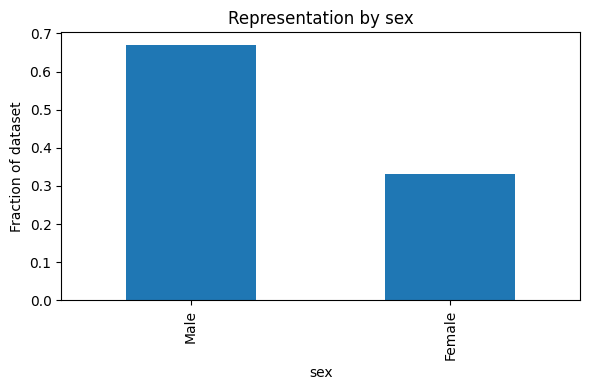


Distribution for sex:
 sex
Male      0.669
Female    0.331
Name: proportion, dtype: float64


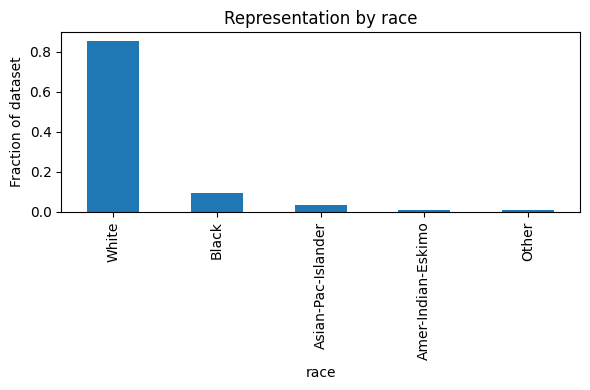


Distribution for race:
 race
White                 0.854
Black                 0.096
Asian-Pac-Islander    0.032
Amer-Indian-Eskimo    0.010
Other                 0.008
Name: proportion, dtype: float64


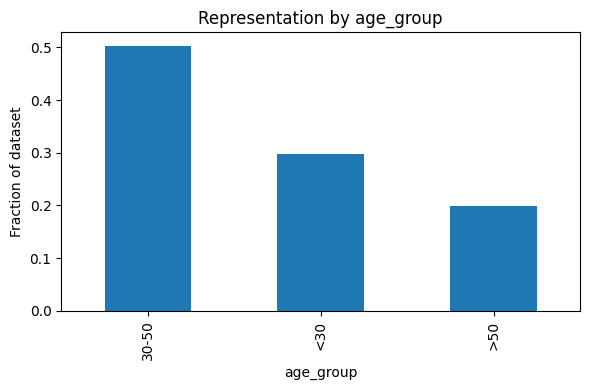


Distribution for age_group:
 age_group
30-50    0.503
<30      0.298
>50      0.198
Name: proportion, dtype: float64


In [46]:
def representation_analysis(df: pd.DataFrame,
                            dataset_name: str,
                            protected_cols: list):
    print(f"\n=== {dataset_name}: Representation Analysis ===")
    for col in protected_cols:
        if col not in df.columns:
            print(f"- Skipping {col}: not in dataset")
            continue

        dist = df[col].value_counts(normalize=True)
        ax = dist.plot(kind="bar")
        ax.set_title(f"Representation by {col}")
        ax.set_ylabel("Fraction of dataset")
        plt.tight_layout()
        plt.show()

        print(f"\nDistribution for {col}:\n", dist.round(3))

representation_analysis(df_min, "Adult Income", protected_cols_extended)


## 8. Outcome rate by protected group

Compute the mean label(`income` = 1) by:sex, race and age group

regulatory:

- Shows historical disparities (bias in the data itself)
- If men have much higher `>50K` rate than women, any model learned from this might replicate those patterns.



=== Adult Income: Outcome Rate by Protected Group ===


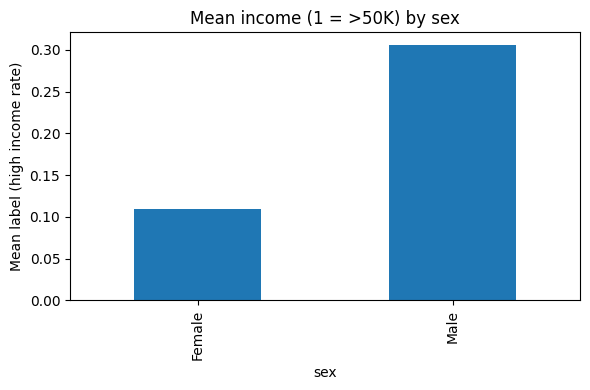


Group-wise mean income for sex:
 sex
Female    0.109
Male      0.306
Name: income, dtype: float64


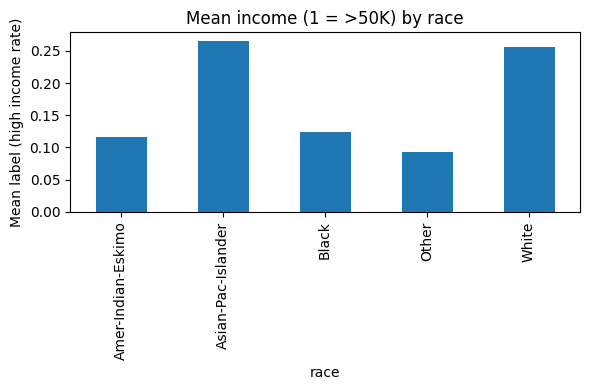


Group-wise mean income for race:
 race
Amer-Indian-Eskimo    0.116
Asian-Pac-Islander    0.266
Black                 0.124
Other                 0.092
White                 0.256
Name: income, dtype: float64


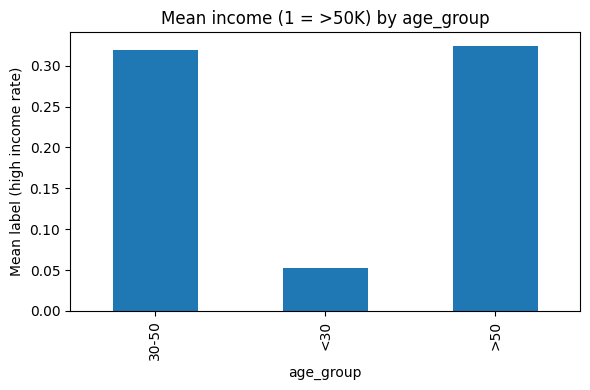


Group-wise mean income for age_group:
 age_group
30-50    0.319
<30      0.053
>50      0.325
Name: income, dtype: float64


In [48]:
def approval_rate_by_group(df: pd.DataFrame,
                           dataset_name: str,
                           target_col: str,
                           protected_cols: list):
    print(f"\n=== {dataset_name}: Outcome Rate by Protected Group ===")
    for col in protected_cols:
        if col not in df.columns:
            continue

        group_means = df.groupby(col)[target_col].mean()
        ax = group_means.plot(kind="bar")
        ax.set_title(f"Mean {target_col} (1 = >50K) by {col}")
        ax.set_ylabel("Mean label (high income rate)")
        plt.tight_layout()
        plt.show()

        print(f"\nGroup-wise mean {target_col} for {col}:\n", group_means.round(3))

approval_rate_by_group(df_min, "Adult Income", target_col, protected_cols_extended)


Men have higher high-income rates than women

Some race groups have consistently lower >50K rates

Great discussion material for ethics & fairness.

## 9. Fairness metrics with Fairlearn



In [49]:
def fairness_metrics(df: pd.DataFrame,
                     y_true: np.ndarray,
                     y_pred: np.ndarray,
                     protected_cols: list):
    print("\n=== Fairlearn Metrics (using labels as proxy decisions) ===")
    for col in protected_cols:
        if col not in df.columns:
            continue

        g = df[col]
        mf = MetricFrame(
            metrics={"selection_rate": selection_rate, "accuracy": accuracy_score},
            y_true=y_true,
            y_pred=y_pred,
            sensitive_features=g
        )

        print(f"\nBy group: {col}")
        print("Selection rate by group:\n", mf.by_group["selection_rate"].round(3))
        print("Accuracy by group:\n", mf.by_group["accuracy"].round(3))
        print("Selection rate difference:", mf.difference()["selection_rate"])

y_true = df_min[target_col].values
y_pred = y_true  # placeholder (baseline: "system exactly matches label distribution")

fairness_metrics(df_min, y_true, y_pred, protected_cols_extended)



=== Fairlearn Metrics (using labels as proxy decisions) ===

By group: sex
Selection rate by group:
 sex
Female    0.109
Male      0.306
Name: selection_rate, dtype: float64
Accuracy by group:
 sex
Female    1.0
Male      1.0
Name: accuracy, dtype: float64
Selection rate difference: 0.19627598779361352

By group: race
Selection rate by group:
 race
Amer-Indian-Eskimo    0.116
Asian-Pac-Islander    0.266
Black                 0.124
Other                 0.092
White                 0.256
Name: selection_rate, dtype: float64
Accuracy by group:
 race
Amer-Indian-Eskimo    1.0
Asian-Pac-Islander    1.0
Black                 1.0
Other                 1.0
White                 1.0
Name: accuracy, dtype: float64
Selection rate difference: 0.17338911598933124

By group: age_group
Selection rate by group:
 age_group
30-50    0.319
<30      0.053
>50      0.325
Name: selection_rate, dtype: float64
Accuracy by group:
 age_group
30-50    1.0
<30      1.0
>50      1.0
Name: accuracy, dtype: float64